In [4]:
import pandas as pd
import numpy as np


In [6]:
np.random.seed(42)
rows = 1200
data = {
    "temperature": np.random.normal(65, 6, rows),       # °C
    "pressure": np.random.normal(30, 4, rows),          # bar
    "vibration": np.random.normal(0.4, 0.1, rows),      # mm/s
    "operating_hours": np.random.randint(100, 5000, rows)
}

df = pd.DataFrame(data)

# Failure risk score (0 = healthy, 1 = high risk)
risk = (
    0.03 * (df["temperature"] - 65) +
    0.02 * (df["pressure"] - 30) +
    2.5 * (df["vibration"] - 0.4) +
    0.0003 * df["operating_hours"] +
    np.random.normal(0, 0.3, rows)
)

df["failure_risk"] = (risk > 0.5).astype(int)
df.to_csv("sensor_data.csv", index=False)
print("Sensor dataset generated successfully!")


Sensor dataset generated successfully!


In [8]:

df = pd.read_csv("sensor_data.csv")
df.head()


,temperature,pressure,vibration,operating_hours,failure_risk
0,67.980285,30.500898,0.327826,1240,0
1,64.170414,28.282378,0.417682,2414,1
2,68.886131,30.489190,0.345332,2632,1
3,74.138179,32.173192,0.372834,3680,1
4,63.595080,30.195440,0.567345,1287,0


In [13]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temperature      1200 non-null   float64
 1   pressure         1200 non-null   float64
 2   vibration        1200 non-null   float64
 3   operating_hours  1200 non-null   int64  
 4   failure_risk     1200 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 47.0 KB


,temperature,pressure,vibration,operating_hours,failure_risk
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,65.230293,30.098607,0.401676,2521.082500,0.647500
std,5.930372,3.934987,0.102305,1406.613363,0.477948
min,45.552396,17.921951,0.100886,101.000000,0.000000
25%,61.249972,27.432021,0.329292,1232.500000,0.000000
50%,65.289820,30.049251,0.401701,2621.000000,1.000000
75%,69.056084,32.690582,0.469277,3708.250000,1.000000
max,88.116389,42.772430,0.792624,4999.000000,1.000000


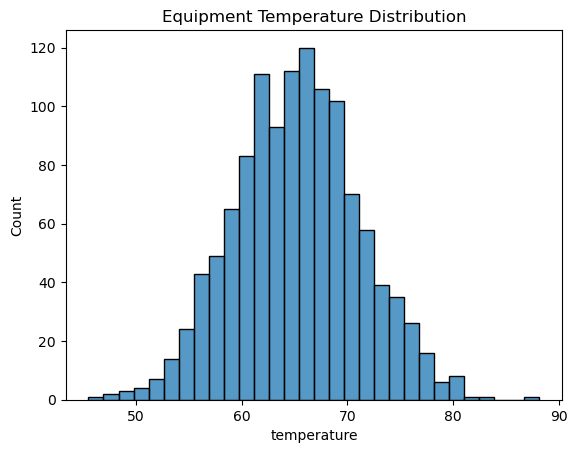

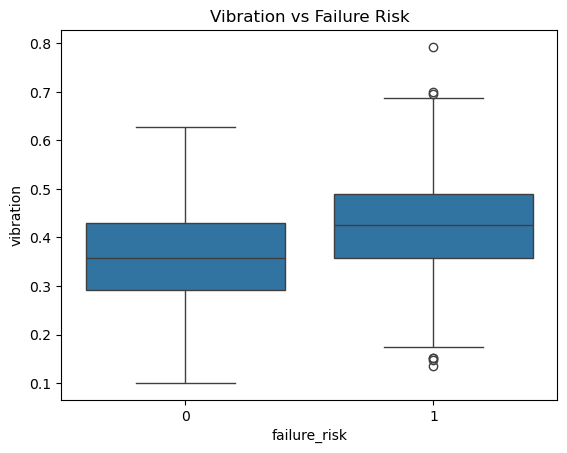

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df["temperature"], bins=30)
plt.title("Equipment Temperature Distribution")
plt.show()

sns.boxplot(x=df["failure_risk"], y=df["vibration"])
plt.title("Vibration vs Failure Risk")
plt.show()

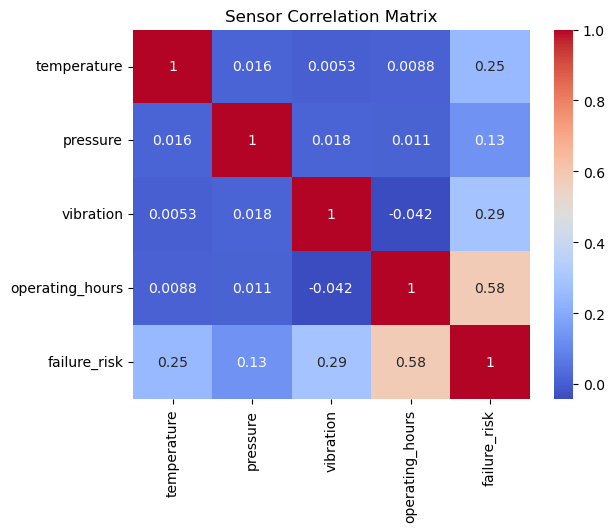

In [19]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Sensor Correlation Matrix")
plt.show()


Observation:
->Equipment with high vibration and temperature shows higher failure risk.
->This is similar to abnormal vitals in medical diagnosis.

Feature & Target Selection

In [22]:
X = df.drop("failure_risk", axis=1)
y = df["failure_risk"]


In [24]:
#Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
# Model Training (Random Forest)
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [28]:
#Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.80      0.78      0.79        76
           1       0.90      0.91      0.90       164

    accuracy                           0.87       240
   macro avg       0.85      0.84      0.84       240
weighted avg       0.87      0.87      0.87       240



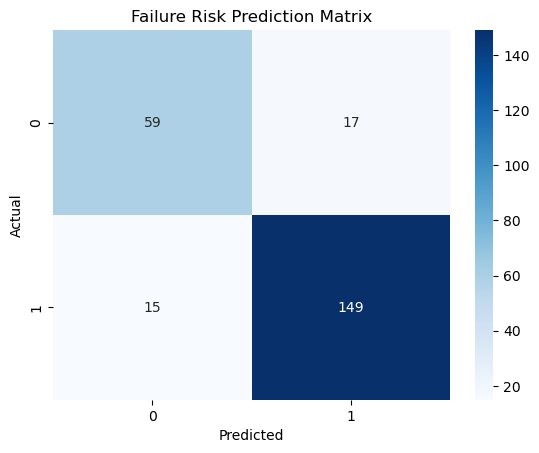

In [30]:
#Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Failure Risk Prediction Matrix")
plt.show()

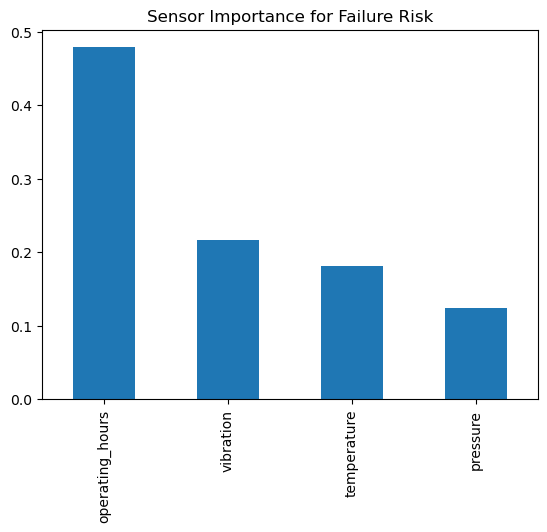

In [32]:
#Feature Importance
import pandas as pd

importance = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importance.plot(kind="bar")
plt.title("Sensor Importance for Failure Risk")
plt.show()


Model Insight:
-> Vibration and operating hours are the most important factors contributing to failure risk.
-> This is similar to how abnormal vital signs indicate health deterioration in medical diagnosis.

In [34]:
# Threshold-based Risk Categories
# Predict probability instead of just 0/1
risk_prob = model.predict_proba(X)[:, 1]

df["risk_probability"] = risk_prob

# Risk categories
def categorize_risk(p):
    if p > 0.7:
        return "High Risk"
    elif p > 0.4:
        return "Medium Risk"
    else:
        return "Low Risk"

df["risk_category"] = df["risk_probability"].apply(categorize_risk)

df[["temperature", "vibration", "operating_hours", "risk_category"]].head()


,temperature,vibration,operating_hours,risk_category
0,67.980285,0.327826,1240,Low Risk
1,64.170414,0.417682,2414,High Risk
2,68.886131,0.345332,2632,High Risk
3,74.138179,0.372834,3680,High Risk
4,63.595080,0.567345,1287,Low Risk


In [36]:
# Maintenance Recommendation Logic
def maintenance_action(row):
    if row["risk_category"] == "High Risk":
        return "Immediate inspection and preventive maintenance"
    elif row["risk_category"] == "Medium Risk":
        return "Schedule maintenance in next cycle"
    else:
        return "Normal operation"

df["recommended_action"] = df.apply(maintenance_action, axis=1)

df[["risk_category", "recommended_action"]].value_counts()


risk_category  recommended_action                             
High Risk      Immediate inspection and preventive maintenance    737
Low Risk       Normal operation                                   411
Medium Risk    Schedule maintenance in next cycle                  52
Name: count, dtype: int64

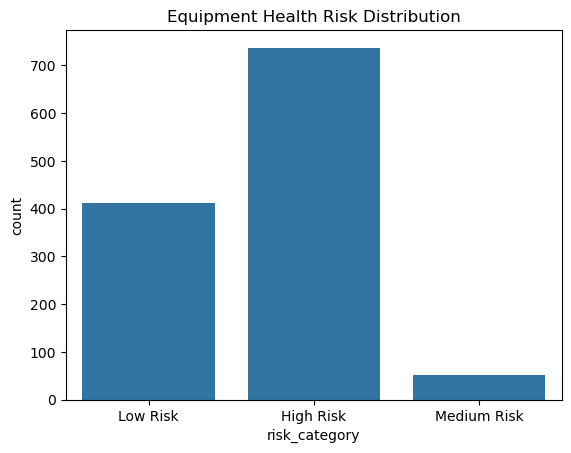

In [38]:
# Visualize Risk Distribution
sns.countplot(x="risk_category", data=df)
plt.title("Equipment Health Risk Distribution")
plt.show()

Improvement Proposal:

Based on the predicted failure risk, equipment is categorized into low, medium, and high-risk groups.

    ->High-risk equipment should undergo immediate preventive maintenance to avoid unplanned downtime.
    ->Medium-risk equipment can be scheduled for inspection during the next maintenance cycle.
    ->Low-risk equipment can continue normal operation.

This approach reduces unexpected failures, improves production stability, and increases overall equipment effectiveness (OEE).